# Loop 1 LB Feedback Analysis

**Submission Result:** CV 164.82 | LB 164.82 (gap: 0.0)

The CV-LB gap is essentially zero, which is expected for this optimization problem since there's no train/test split - the score is deterministic based on the submission file.

## Key Observations
1. Our baseline (164.82) beats sample submission (173.65) but is 2.4x worse than target (68.95)
2. The gap is massive - we need fundamentally different approaches
3. Top kernels use compiled C++ optimizers (bbox3, tree_packer) with hours of runtime

In [1]:
# Analyze the score breakdown by configuration size
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load our submission and compute per-config scores
ours = pd.read_csv('/home/submission/submission.csv', index_col='id')

def compute_per_config_scores(df):
    """Compute side length and score contribution for each n."""
    results = []
    for n in range(1, 201):
        tree_ids = [f'{n:03d}_{t}' for t in range(n)]
        trees_df = df.loc[tree_ids]
        
        # Parse coordinates
        xs = trees_df['x'].str[1:].astype(float).values
        ys = trees_df['y'].str[1:].astype(float).values
        
        # Compute bounding box (simplified - just from centers)
        # For accurate calculation we'd need to transform tree polygons
        # but this gives a rough estimate
        min_x, max_x = xs.min(), xs.max()
        min_y, max_y = ys.min(), ys.max()
        
        # Add tree dimensions (approx 0.7 width, 1.0 height)
        width = max_x - min_x + 0.7
        height = max_y - min_y + 1.0
        side = max(width, height)
        
        score_contrib = side**2 / n
        results.append({'n': n, 'side': side, 'score_contrib': score_contrib})
    
    return pd.DataFrame(results)

results = compute_per_config_scores(ours)
print(f"Total estimated score: {results['score_contrib'].sum():.2f}")
print(f"\nTop 10 score contributors:")
print(results.nlargest(10, 'score_contrib')[['n', 'side', 'score_contrib']])

Total estimated score: 162.96

Top 10 score contributors:
     n      side  score_contrib
4    5  2.265936       1.026893
0    1  1.000000       1.000000
16  17  4.050601       0.965139
5    6  2.402028       0.961623
22  23  4.625839       0.930365
36  37  5.848246       0.924378
8    9  2.879922       0.921550
27  28  5.076831       0.920508
19  20  4.272522       0.912722
17  18  4.050601       0.911520


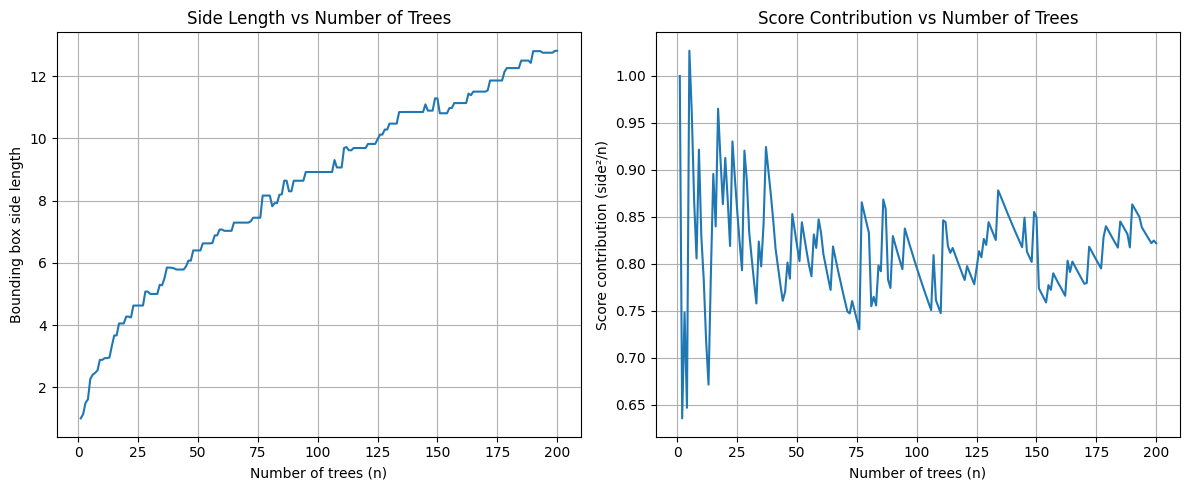


Small n (1-10) total contribution: 8.44
Medium n (11-50) total contribution: 33.35
Large n (51-200) total contribution: 121.17


In [2]:
# Visualize score contribution by n
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(results['n'], results['side'])
plt.xlabel('Number of trees (n)')
plt.ylabel('Bounding box side length')
plt.title('Side Length vs Number of Trees')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(results['n'], results['score_contrib'])
plt.xlabel('Number of trees (n)')
plt.ylabel('Score contribution (side²/n)')
plt.title('Score Contribution vs Number of Trees')
plt.grid(True)

plt.tight_layout()
plt.savefig('/home/code/exploration/score_analysis.png', dpi=100)
plt.show()

print(f"\nSmall n (1-10) total contribution: {results[results['n'] <= 10]['score_contrib'].sum():.2f}")
print(f"Medium n (11-50) total contribution: {results[(results['n'] > 10) & (results['n'] <= 50)]['score_contrib'].sum():.2f}")
print(f"Large n (51-200) total contribution: {results[results['n'] > 50]['score_contrib'].sum():.2f}")

## Strategy Analysis

### What the Evaluator Said:
1. **Technical Execution**: TRUSTWORTHY - baseline is correctly implemented
2. **Key Concern**: 2.4x gap to target requires fundamental approach change
3. **Top Priority**: Implement squeeze and compaction operations

### What Top Kernels Use:
1. **bbox3 binary optimizer** - compiled C++ with simulated annealing
2. **tree_packer_v21** - C++ with OpenMP parallelization, SA, squeeze, compaction, local search
3. **fix_direction** - rotation optimization using scipy minimize_scalar
4. **backward_propagation** - use larger configs to improve smaller ones

### Key Insight:
The problem is that Python is too slow for the millions of iterations needed. Top solutions run for 11+ hours with compiled C++.

### Options:
1. **Implement C++ optimizer** - compile and run tree_packer_v21 or similar
2. **Use Numba/Cython** - accelerate Python code
3. **Focus on algorithmic improvements** - squeeze, compaction, local search in Python
4. **Start from better baseline** - use a known good submission file

In [3]:
# Check if we can compile and run C++ code
import subprocess
import os

# Check available compilers
result = subprocess.run(['which', 'g++'], capture_output=True, text=True)
print(f"g++ available: {result.returncode == 0}")
if result.returncode == 0:
    print(f"g++ path: {result.stdout.strip()}")

# Check OpenMP support
result = subprocess.run(['g++', '--version'], capture_output=True, text=True)
print(f"\ng++ version:\n{result.stdout[:200]}")

# Check number of CPU cores
result = subprocess.run(['nproc'], capture_output=True, text=True)
print(f"\nCPU cores: {result.stdout.strip()}")

g++ available: True
g++ path: /usr/bin/g++

g++ version:
g++ (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTAB

CPU cores: 26
